# Teoría de Decisiones: Modelo Schelling con Sugarscape.
    
- Eduardo Carrasco.

Parámetros del Modelo
- Agentes: Dos tipos - Rojos y Azules.
- Capacidad de Almacenamiento de Azúcar:
    - Rojos: Entre 1 y 4 azúcares.
    - Azules: Más de 4 azúcares.
- Consumo de Azúcar: 1 azúcar por turno para todos los agentes.
- Cantidad Inicial de Azúcar: Aleatoria entre 1 y 10 para todos los agentes.
- Infelicidad: Ocurre cuando hay agentes de diferentes tipos en la misma vecindad.

## Librerías Base:

In [ ]:
import matplotlib.colors as mcolors
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
import random
import pandas as pd
from scipy.stats import entropy
from scipy.ndimage import label

## 1. Definición de funciones (1ra Línea de Investigación - Modelo Tolerancia):

In [ ]:
def inicializar_grilla(n, p):
    """
    Inicializa una grilla bidimensional con celdas vacías, 
    azules y rojas según las probabilidades proporcionadas.
    Args:
        n (int): Tamaño de la grilla (n x n).
        p (list): Lista de probabilidades [p_vacía, p_azul, p_roja].

    Returns:
        np.ndarray: Grilla inicializada.
    """
    grilla = np.random.choice([0, 1, 2], size=(n, n), p=p)
    return grilla

def vecindad(posicion, grilla):
    """
    Determina una vecindad de Moore
    posicion (x,y) : celda a la cual vamos a conocer sus vecinos
    grilla : grilla para conocer vecinos
    """
    n,n = grilla.shape
    x, y = posicion
    vecindad = { "N":  grilla[(x-1) % n , y ],      ## % n para que se mantenga dentro: genera un toroide
                 "E":  grilla[ x , (y+1) % n] , 
                 "S":  grilla[(x+1) % n , y ],
                 "O":  grilla[ x , (y-1) % n],
                 "NO": grilla[(x-1) % n , (y-1) % n],
                 "NE": grilla[(x-1) % n , (y+1) % n],
                 "SO": grilla[(x+1) % n , (y-1) % n],
                 "SE": grilla[(x+1) % n , (y+1) % n]}
    return vecindad

def felicidad(posicion, grilla, t):
    """
    Calculo de felicidad de una celda
    posicion(x,y) : posicion a al cual vamos a determinar la felicidad, 
    dado si la cantidad de celdas iguales es igual o mayor a t (tolerancia)
    grilla : grilla base
    t: Cantidad de vecinos que soporta una celula para estar feliz. 
    Si la cantidad de vecinos difetentes a ella es menor a t, la celula esta feliz
    """
    nb = vecindad(posicion, grilla)
    cantidad_diferentes = 0
    
    for i in nb:
        if grilla[posicion] != nb[i] and grilla[posicion] != 0 and  nb[i]!=0:  
            # Si el vecino es diferente al individuo central suma 1
            cantidad_diferentes += 1
    if cantidad_diferentes <= t:         
        # si la cantidad de celdas diferentes de la vecindad es menor al umbral el individuo es feliz
        return True
    elif grilla[posicion] == 0:          
        # asume celdas cero felices por lo que los ceros no se mueven
        return True
    else:
        return False
    
def encontrar_celdas_infelices(grilla, t):
    """
    Encuentra todas las celdas infelices en la grilla según la tolerancia t.

    Args:
        grilla (np.ndarray): Grilla bidimensional.
        t (int): Tolerancia.

    Returns:
        list: Lista de índices de celdas infelices.
    """
    celdas_infelices = []
    n = grilla.shape[0]
    for i in range(n):
        for j in range(n):
            posicion = (i,j)
            if grilla[posicion ] != 0 and felicidad(posicion, grilla, t) == False:
                celdas_infelices.append(posicion)  # Convertir a índice unidimensional
    return celdas_infelices

def movimiento(posicion, grilla):
    x , y = posicion 
    grilla_aux = grilla.copy()
    direccion = [ "N", "E" ,"S","O", "NO","NE", "SO", "SE"]
    nb =  vecindad(posicion, grilla_aux)
    np.random.shuffle(direccion)
    for i in direccion:
        if nb[i] == 0:
            if i == "N":  
                grilla_aux[(x-1) % n , y ] = grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i == "E":  
                grilla_aux[ x , (y+1) % n] = grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i == "S":  
                grilla_aux[(x+1) % n , y ] = grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i =="O":  
                grilla_aux[ x , (y-1) % n] = grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i =="NO": 
                grilla_aux[(x-1) % n , (y-1) % n]= grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i =="NE": 
                grilla_aux[(x-1) % n , (y+1) % n]= grilla_aux[posicion]
                grilla_aux[posicion] =0
            elif i =="SO": 
                grilla_aux[(x+1) % n , (y-1) % n]= grilla_aux[posicion]
                grilla_aux[posicion] =0
            else:
                grilla_aux[(x+1) % n , (y+1) % n]= grilla_aux[posicion]
                grilla_aux[posicion] =0
                
    return grilla_aux    
    

def crear_gif(automata, n, pasos, p):
    nombre_archivo = f"SAKODA_size{n}_pasos{pasos}_dist{p}.gif"

    # Crear un mapa de colores personalizado
    cmap = mcolors.ListedColormap(['white', 'blue', 'red'])

    imagenes = []
    for idx, matriz in enumerate(automata):
        imagen = plt.imshow(matriz, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
        titulo = f"Generación {idx} \nDistr (vacio,azul,rojo) {p}"
        plt.title(titulo)
        plt.axis('on')
        filename = "temp.png"
        plt.savefig(filename)
        plt.close()

        image = imageio.v2.imread(filename)
        os.remove(filename)
        imagenes.append(image)

    imageio.mimsave(nombre_archivo, imagenes, fps=10)
    
def modelo_sakoda_schelling(n, p, t, pasos):
    """
    Ejecuta el modelo de Sakoda/Schelling y devuelve una lista de grillas.

    Args:
        n (int): Tamaño de la grilla (n x n).
        p (list): Lista de probabilidades [p_vacía, p_azul, p_roja].
        t (int): Tolerancia.
        pasos (int): Número de pasos a ejecutar.

    Returns:
        list: Lista de grillas.
    """
    grilla = inicializar_grilla(n, p)
    grillas = [grilla.copy()]  # Agregar la grilla inicial a la lista de grillas
    
    for s in range(pasos):
        celdas_infelices = encontrar_celdas_infelices(grillas[-1], t)
        if len(celdas_infelices) == 0:
            break
        celda = random.choice(celdas_infelices)
        nueva_grilla = movimiento(celda, grillas[-1])
        grillas.append(nueva_grilla)  # Agregar la grilla actualizada a la lista de grillas
    
    return grillas

def calcular_infelices(automata, t):
    """
    Calcula la cantidad de celdas infelices en cada paso.

    Args:
        automata (list): Lista de grillas.
        t (int): Tolerancia.

    Returns:
        list: Lista de cantidades de celdas infelices.
    """
    infelices = []
    for grilla in automata:
        celdas_infelices = encontrar_celdas_infelices(grilla, t)
        infelices.append(len(celdas_infelices))
    return infelices

### 1.1. Definición de Parámetros y Simulación:

In [ ]:
random.seed(123)  # semilla random
np.random.seed(123)  # semilla NumPy

# Parámetros de entrada
n = 30  # Tamaño de la grilla (n x n)
p = [0.2, 0.4, 0.4]  # Probabilidad de celdas vacías, azules y rojas respectivamente
t = 2  # Tolerancia
pasos =10000 # Número de pasos

# Ejecutar el modelo de Sakoda/Schelling
automata = modelo_sakoda_schelling(n, p, t, pasos)

# Calcular la cantidad de celdas infelices en cada paso
infelices = calcular_infelices(automata, t)

len(automata)

### 1.2. Generación de Gráfico:

In [ ]:
# Definir tamaño de la figura

iter_figuras = (0,50,100,200,800,1000,2500,5000,7500,10000)
fig, axes = plt.subplots(2,5, figsize = (13,6)) #    tres gráficos en una fila, ajustar según página d eword

for h in range(2):
    for g in range(5):
        axes[h,g].set_axis_off()
            
    for j in range(len(iter_figuras)):
        ax = fig.add_subplot(2, 5, j+1)       # i+1 porque los subplots se numeran desde 1
        cmap = mcolors.ListedColormap(['white', 'blue', 'red'])
        plt.imshow(automata[iter_figuras[j]], cmap=cmap, vmin=0, vmax=2, interpolation='nearest')
        ax.set_title("it: "+ str(iter_figuras[j]))
        ax.axis('off')
        # Ajustar la disposición de los subplots y mostrar la figura
    fig.tight_layout()

### 1.3. Métricas:

#### 1.3.1. Cantidad de Infelices en el tiempo:

In [ ]:
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(8, 4))

# Graficar la cantidad de celdas infelices
ax.plot(infelices, label='Celdas infelices')

# Configurar el gráfico
ax.set_xlabel('Iteración')
ax.set_ylabel('Cantidad de Infelices')
ax.set_title('Celdas Infelices en el Tiempo')
ax.grid()
ax.legend()

# Mostrar el gráfico
plt.show()

### 1.4. Creación Gif:

In [ ]:
### gif con saltos; ojo con la ram, 

def crear_gif(automata, n, pasos, p):
    nombre_archivo = f"SAKODA_size{n}_pasos{pasos}_dist{p}.gif"

    # Crear un mapa de colores personalizado
    cmap = mcolors.ListedColormap(['white', 'blue', 'red'])

    imagenes = []
    for idx, matriz in enumerate(automata):
        imagen = plt.imshow(matriz, cmap=cmap, interpolation='nearest', vmin=0, vmax=2)
        titulo = f"Generación {idx} \nDistr (vacio,azul,rojo) {p}"
        plt.title(titulo)
        plt.axis('off')
        filename = "temp1.png"
        plt.savefig(filename, dpi=50)  ## disminuyo dpi se vuelve más feo pero nmenos pesado
        plt.close()

        image = imageio.v2.imread(filename)
        os.remove(filename)
        imagenes.append(image)
        
    salto = 25        # Saltar cuadros (cambiar según la velocidad deseada)
    imagenes_reducidas = imagenes[::salto]  # Obtener una lista reducida de cuadros

    imageio.mimsave(nombre_archivo, imagenes_reducidas, fps=100) 
    
crear_gif(automata, n, pasos, p)

________

____

_____

# Descripción Detallada del Modelo (Combinación de Schelling con Sugarscape):

**Eduardo Carrasco Vidal** (Estudiante Doctorado en Ingeniería de Sistemas Complejos, UAI).


## Introducción

Este modelo simula la interacción de dos tipos de agentes (rojos y azules) en una grilla bidimensional. Cada agente tiene atributos como tipo, nivel de azúcar y estado de ánimo. La simulación busca entender cómo estos agentes interactúan y cómo sus atributos cambian con el tiempo.

## Características del Modelo

### Espacio de Simulación

1. **Tamaño de la Grilla**: La grilla es de `30 x 30` celdas.

### Agentes

1. **Cantidad de Agentes**: 
  - **Agentes Rojos**: 300
  - **Agentes Azules**: 300

2. **Atributos Iniciales de los Agentes**:
  - **Agentes Rojos**: 
    - Nivel inicial de azúcar: Aleatorio entre 1 y 10.
  - **Agentes Azules**: 
    - Nivel inicial de azúcar: Aleatorio entre 30 y 40.
    
### Reglas de Interacción

1. **Umbral de Riqueza**: 50 unidades de azúcar.

### Condiciones para el Movimiento

1. **Infelicidad**: Un agente se mueve si está infeliz, lo cual se determina por la cantidad de vecinos del mismo tipo y del tipo opuesto que tiene. Si el número de vecinos del tipo opuesto es igual o mayor al número de vecinos del mismo tipo, el agente se considera _infeliz_ y se mueve.
2. **Nivel de Azúcar**: Independientemente de su estado de felicidad, un agente también se moverá si su nivel de azúcar es menor a un umbral específico (en este caso, 50 unidades de azúcar).

### Restricciones en el Movimiento

1. **Movimiento Aleatorio**: Cuando un agente decide moverse, selecciona una nueva ubicación al azar en la grilla.
2. **Espacio Disponible**: Un agente solo puede moverse a una celda vacía. Si la celda seleccionada al azar está ocupada, el agente continuará buscando hasta encontrar una celda vacía.
3. **Movimiento Limitado por Riqueza**: Si un agente tiene un nivel de azúcar menor al umbral de riqueza (en este caso, 50 unidades de azúcar), su capacidad de movimiento se limita a 2 posiciones de las 8 posibles alrededor de él. Si tiene suficiente riqueza, puede moverse a cualquiera de las 8 posiciones circundantes.

### Recolección y consumo de Azúcar:
1. **Agentes Rojos**: Recogen entre 0 y 3 unidades de azúcar por turno.
2. **Agentes Azules**: Recogen entre 1 y 10 unidades de azúcar por turno.
3. **Consumo de Azúcar**: Todos los agentes consumen 1 unidad de azúcar por turno.

### Métricas de Simulación:

- **Agentes Infelices**: Se registra el número de agentes infelices en cada turno.
- **Azúcar Promedio**: Se calcula el azúcar promedio para cada tipo de agente en cada turno.
- **Agentes Vivos**: Se cuenta el número de agentes vivos de cada tipo en cada turno.

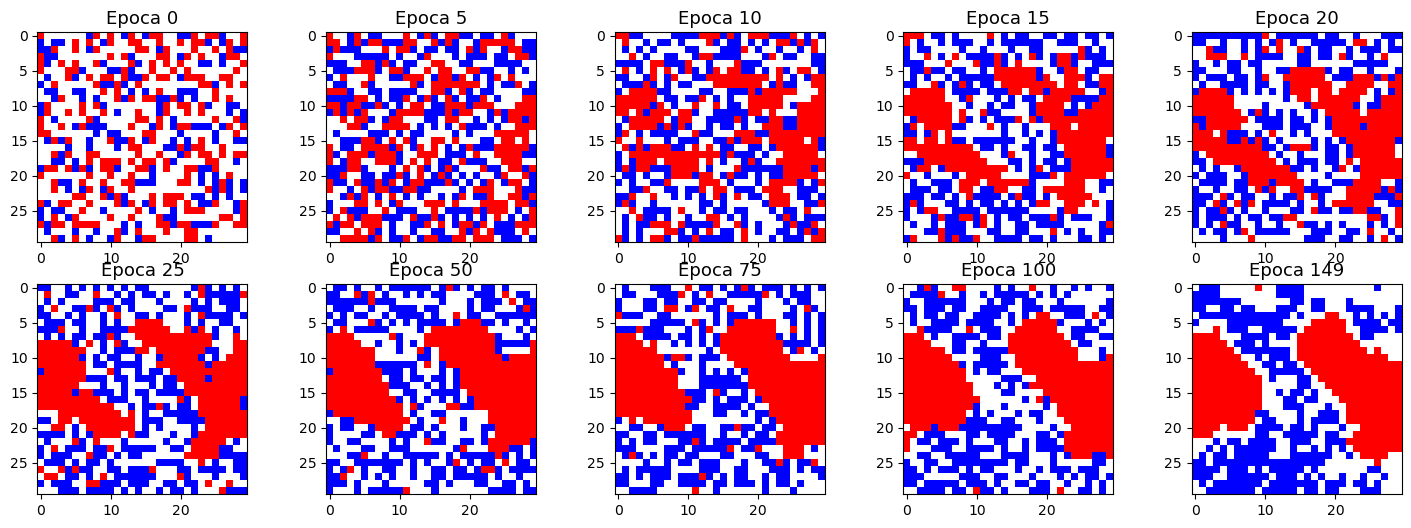

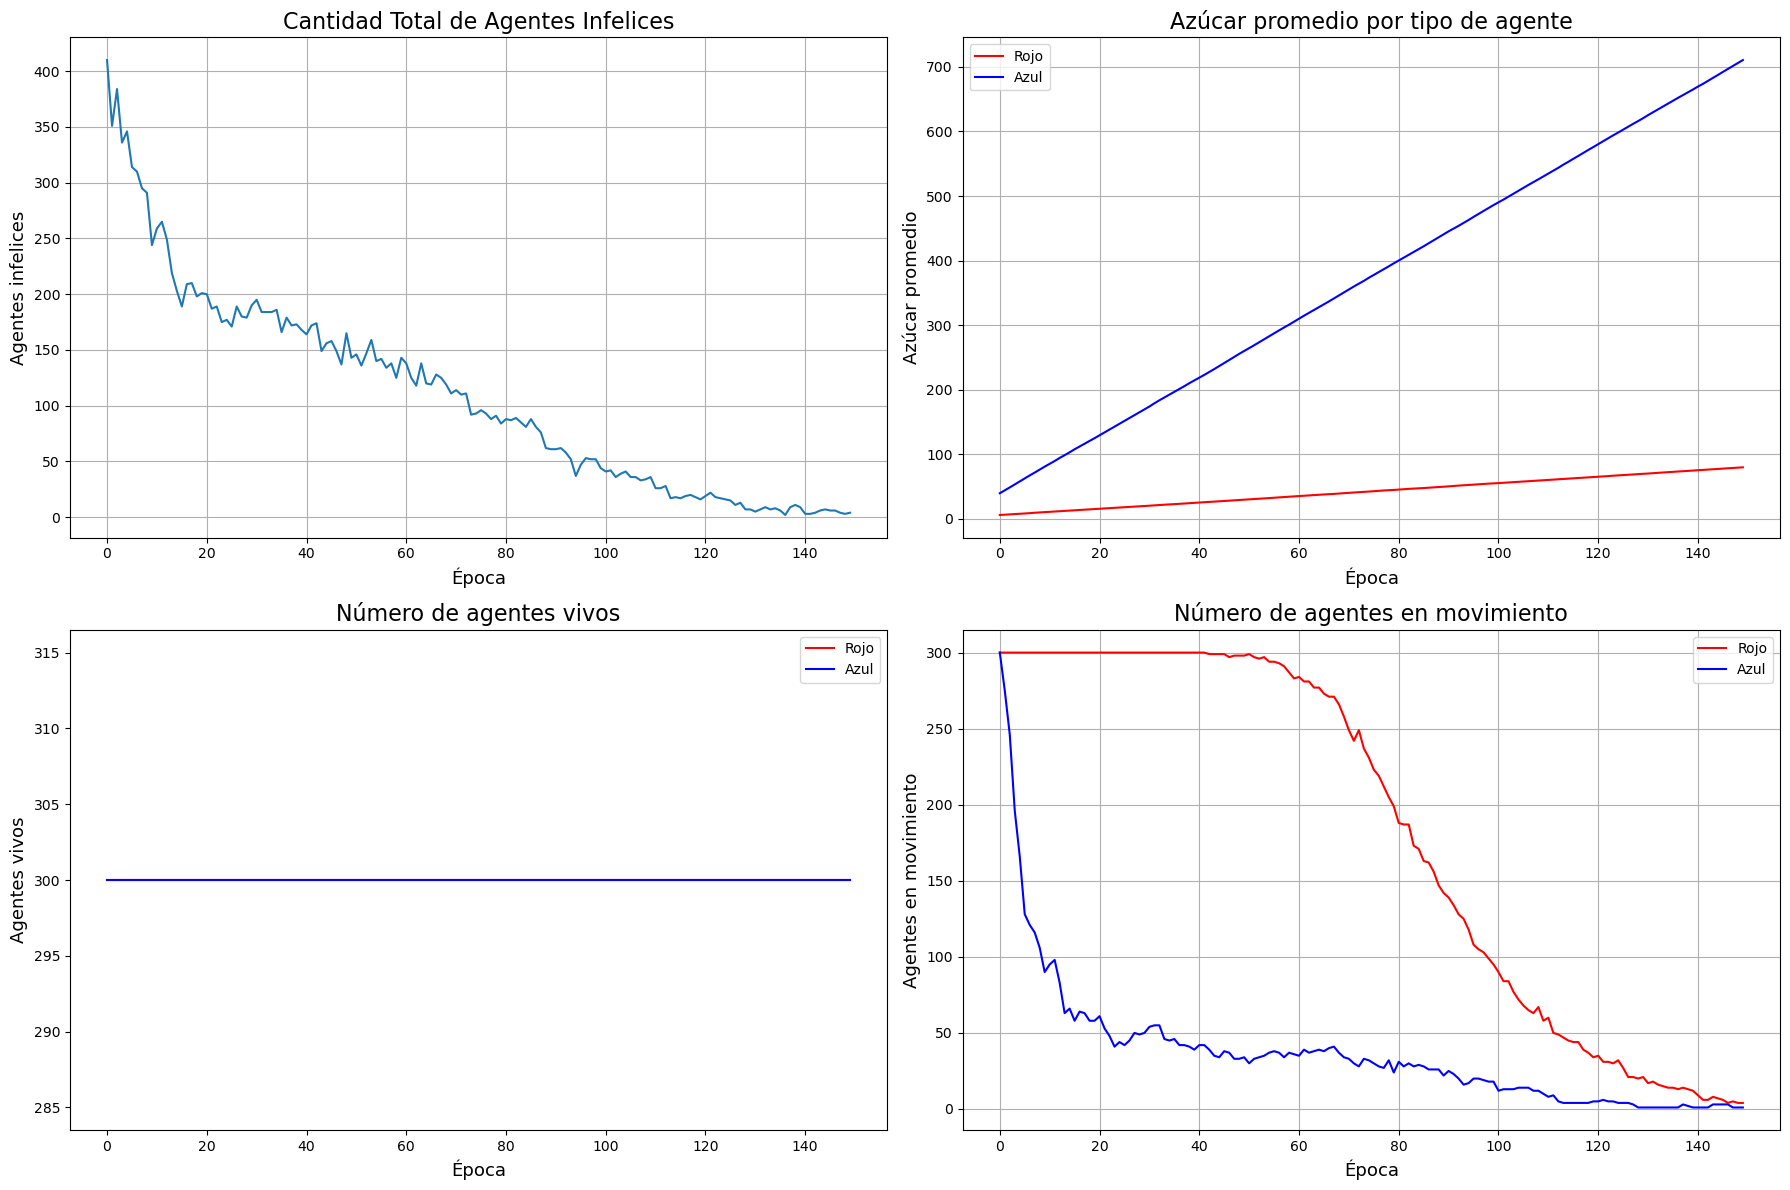

In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

random.seed(218)
np.random.seed(218)

# Crear un mapa de colores personalizado
custom_cmap = ListedColormap(['white', 'blue', 'red'])

# Función para visualizar la grilla
def plot_grid(grid, step, subplot_position):
    plt.subplot(2, 5, subplot_position)
    plt.imshow(grid, cmap=custom_cmap)
    plt.title(f"Epoca {step}", fontsize=13)

# Parámetros de la simulación
grid_size = 30  # Tamaño de la grilla
n_red_agents = 300  # Número de agentes rojos
n_blue_agents = 300  # Número de agentes azules

# Inicializar la grilla y los agentes
grid = np.zeros((grid_size, grid_size), dtype=int)
agents = []

# Clase para representar a los agentes
class Agent:
    def __init__(self, agent_type, sugar, x, y):
        self.agent_type = agent_type  # Tipo de agente ('red' o 'blue')
        self.sugar = sugar  # Cantidad de azúcar
        self.x = x  # Posición en x
        self.y = y  # Posición en y
        self.unhappy = False  # Estado de felicidad

# Umbral de riqueza (en unidades de azúcar)
wealth_threshold = 40
        
# Crear agentes rojos y azules con posiciones y azúcar aleatorias
for _ in range(n_red_agents):
    x, y = np.random.randint(0, grid_size, size=2)
    sugar = random.randint(1, 10)
    agents.append(Agent('red', sugar, x, y))
    grid[x, y] = 1

for _ in range(n_blue_agents):
    x, y = np.random.randint(0, grid_size, size=2)
    sugar = random.randint(30, 40)
    agents.append(Agent('blue', sugar, x, y))
    grid[x, y] = 2

# Función para verificar la infelicidad de un agente
def check_unhappiness(agent):
    x, y = agent.x, agent.y
    # Vecinos posibles (8 direcciones)
    all_neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1), (x-1, y-1), (x+1, y+1), (x-1, y+1), (x+1, y-1)]
    
    # Limitar las opciones de movimiento para agentes menos ricos
    if agent.sugar < wealth_threshold:
        neighbors = all_neighbors[:2]  # Solo se puede mover a 2 posiciones de las 8
    else:
        neighbors = all_neighbors  # Todos los vecinos
    
    same_count = 0
    different_count = 0
    
    # Contar vecinos del mismo y diferente tipo
    for nx, ny in neighbors:
        if 0 <= nx < grid_size and 0 <= ny < grid_size:
            neighbor_type = grid[nx, ny]
            if neighbor_type != 0:
                if neighbor_type == (1 if agent.agent_type == 'red' else 2):
                    same_count += 1
                else:
                    different_count += 1
    
    # Determinar si el agente está infeliz
    if different_count >= same_count:
        agent.unhappy = True
    else:
        agent.unhappy = False

# Inicializar métricas
unhappy_count = []  # Contador de agentes infelices
average_sugar_red = []  # Azúcar promedio para agentes rojos
average_sugar_blue = []  # Azúcar promedio para agentes azules
alive_count_red = []  # Contador de agentes rojos vivos
alive_count_blue = []  # Contador de agentes azules vivos
moved_count_red = []  # Contador de agentes rojos que se movieron
moved_count_blue = []  # Contador de agentes azules que se movieron

# Simulación principal
plt.figure(figsize=(18, 6))  # Ajustar el tamaño de la figura

for t in range(150):
    # Visualizar la grilla en pasos específicos
    if t in [0, 5, 10, 15, 20, 25, 50, 75, 100, 149]:
        plot_position = {0: 1, 5: 2, 10: 3, 15: 4, 20: 5, 
                         25: 6, 50: 7, 75: 8, 100: 9, 149: 10}  # Posiciones de los subgráficos
        plot_grid(grid, t, plot_position[t])
        
    unhappy_agents = 0
    total_sugar_red = 0
    total_sugar_blue = 0
    alive_agents_red = 0
    alive_agents_blue = 0
    moved_agents_red = 0 
    moved_agents_blue = 0  
    
    for agent in agents:
        # Recolectar azúcar (simulado)
        if agent.agent_type == 'red':
            agent.sugar += random.randint(0, 3)
        else:  # agent.agent_type == 'blue'
            agent.sugar += random.randint(1, 10)
        
        # Consumir azúcar
        agent.sugar -= 1
        
        # Verificar infelicidad
        check_unhappiness(agent)
        
        # Contar agentes infelices y azúcar total
        unhappy_agents += int(agent.unhappy)
        if agent.agent_type == 'red':
            total_sugar_red += agent.sugar
            alive_agents_red += 1
        else:
            total_sugar_blue += agent.sugar
            alive_agents_blue += 1
            
        # Mover si está infeliz o si tiene menos de 50 unidades de azúcar
        if agent.unhappy or agent.sugar < 50:
            new_x, new_y = np.random.randint(0, grid_size, size=2)
            while grid[new_x, new_y] != 0:
                new_x, new_y = np.random.randint(0, grid_size, size=2)
            grid[agent.x, agent.y] = 0
            grid[new_x, new_y] = 1 if agent.agent_type == 'red' else 2
            agent.x, agent.y = new_x, new_y
            agent.unhappy = False
            
            if agent.agent_type == 'red':
                moved_agents_red += 1
            else:
                moved_agents_blue += 1
            
    # Registrar métricas
    unhappy_count.append(unhappy_agents)
    average_sugar_red.append(total_sugar_red / alive_agents_red if alive_agents_red > 0 else 0)
    average_sugar_blue.append(total_sugar_blue / alive_agents_blue if alive_agents_blue > 0 else 0)
    alive_count_red.append(alive_agents_red)
    alive_count_blue.append(alive_agents_blue)
    moved_count_red.append(moved_agents_red)
    moved_count_blue.append(moved_agents_blue)

# Visualización de métricas
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.plot(unhappy_count)
plt.title('Cantidad Total de Agentes Infelices', fontsize=16)
plt.xlabel('Época', fontsize=13)
plt.ylabel('Agentes infelices', fontsize=13)
plt.grid(True) 

plt.subplot(2, 2, 2)
plt.plot(average_sugar_red, label='Rojo', color='red')
plt.plot(average_sugar_blue, label='Azul', color='blue')
plt.title('Azúcar promedio por tipo de agente', fontsize=16)
plt.xlabel('Época', fontsize=13)
plt.ylabel('Azúcar promedio', fontsize=13)
plt.legend()
plt.grid(True) 

plt.subplot(2, 2, 3)
plt.plot(alive_count_red, label='Rojo', color='red')
plt.plot(alive_count_blue, label='Azul', color='blue')
plt.title('Número de agentes vivos', fontsize=16)
plt.xlabel('Época', fontsize=13)
plt.ylabel('Agentes vivos', fontsize=13)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(moved_count_red, label='Rojo', color='red')
plt.plot(moved_count_blue, label='Azul', color='blue')
plt.title('Número de agentes en movimiento', fontsize=16)
plt.xlabel('Época', fontsize=13)
plt.ylabel('Agentes en movimiento', fontsize=13)
plt.legend()
plt.grid(True) 

plt.tight_layout()
plt.show()

## Comparación del Modelo con Sakoda y Sugarscape

### Diferencias con el Modelo de Sakoda Simple

1. **Agentes con Atributos**: A diferencia del modelo de Sakoda, donde los agentes son generalmente homogéneos y solo se diferencian por su tipo (rojo o azul), en este modelo los agentes tienen un atributo adicional: "sugar" (azúcar), que representa algún tipo de riqueza o recurso.

2. **Movilidad Restringida**: Mientras que en el modelo de Sakoda los agentes pueden moverse libremente si están insatisfechos con sus vecinos, en este modelo la capacidad de moverse está vinculada al nivel de "sugar" del agente. Los agentes con menos de un cierto umbral solo pueden moverse a posiciones limitadas.

3. **Reglas de Infelicidad**: En el modelo de Sakoda, la infelicidad se basa generalmente en la proporción de vecinos del mismo tipo. En este modelo, un agente se considera infeliz si tiene tantos o más vecinos de un tipo diferente que del mismo tipo.

4. **Métricas y Visualización**: Este modelo incluye una serie de métricas y visualizaciones que no están presentes en el modelo de Sakoda simple, como el número de agentes infelices, el azúcar promedio por tipo de agente, entre otros.

### Integración con Sugarscape

1. **Recurso (Azúcar)**: La idea de tener un recurso ("sugar") que los agentes recolectan y consumen es un concepto central en Sugarscape. En este modelo, los agentes tienen un nivel de "sugar" que afecta su comportamiento, lo cual es similar a Sugarscape.

2. **Consumo y Acumulación**: Al igual que en Sugarscape, los agentes en este modelo consumen y acumulan recursos (en este caso, azúcar). Esto podría extenderse para incluir intercambio, herencia, y otras características de Sugarscape.

3. **Movilidad Restringida**: En Sugarscape, la movilidad a menudo está vinculada a la búsqueda de recursos. En este modelo, la movilidad está restringida por el nivel de "sugar", lo cual es una forma de integrar las ideas de movilidad basada en recursos de Sugarscape.

4. **Agentes con Atributos**: Similar a Sugarscape, los agentes en este modelo tienen múltiples atributos (tipo y azúcar), lo que permite una gama más rica de comportamientos y resultados.

En resumen, este modelo es una especie de híbrido entre el modelo de segregación de Sakoda y el modelo económico y social de Sugarscape. Esto lo hace más rico en características y más adaptable a diferentes tipos de análisis.